In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from fastai.conv_learner import *

In [20]:
PATH = 'D:\\FAST.Ai\\Practical Deep Learning For Coders 1 - YouTube\\Data\\understanding amazon\\planet\\'

In [21]:
os.listdir(PATH)


['models',
 'original_train_v2.csv',
 'test-jpg',
 'tmp',
 'train-jpg',
 'train_v2.csv',
 'train_v2.xlsx']

In [22]:
from fastai.plots import *

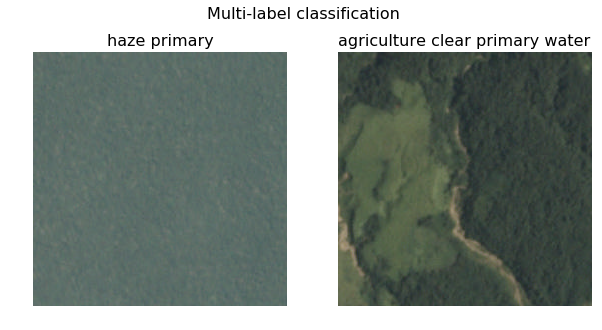

In [23]:
list_paths = [f"{PATH}train-jpg\\train_0.jpg", f"{PATH}train-jpg\\train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [24]:
#!pip install planet

In [13]:
from planet import *

In [19]:
#from planet import f2

ImportError: cannot import name 'f2'

In [25]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [26]:
metrics=[f2]
f_model = resnet34

In [27]:
label_csv = f'{PATH}train_v2.csv'

In [28]:
n = len(list(open(label_csv))) - 1

In [29]:
n

1499

In [30]:
val_idxs = get_cv_idxs(n)

In [31]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    # transforms_top_down means full set of possible transformasions  
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [32]:
sz = 64
data = get_data(sz)

In [33]:
x,y = next(iter(data.val_dl))

In [34]:
list(zip(y[40],data.classes))

[(0.0, 'agriculture'),
 (0.0, 'artisinal_mine'),
 (0.0, 'bare_ground'),
 (0.0, 'blooming'),
 (0.0, 'blow_down'),
 (1.0, 'clear'),
 (0.0, 'cloudy'),
 (0.0, 'conventional_mine'),
 (0.0, 'cultivation'),
 (0.0, 'habitation'),
 (0.0, 'haze'),
 (0.0, 'partly_cloudy'),
 (1.0, 'primary'),
 (0.0, 'road'),
 (0.0, 'selective_logging'),
 (0.0, 'slash_burn'),
 (1.0, 'water')]

In [35]:
x.type()

'torch.FloatTensor'

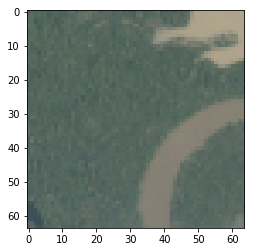

In [36]:
plt.imshow(data.val_ds.denorm(to_np(x))[40] * 1.4)

In [37]:
data.resize(int(sz*1.3) , 'tmp') # it just save time , not allowing photoes bigger than sz*1.3 to go in our data 
#, photoes are rectangle(mitone toolesh sz*1.3 bashe arzaes kamtar)
#(center-cropped)

In [38]:
learn = ConvLearner.pretrained(f_model,data,metrics = metrics)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.729706   0.858894   0.65884   



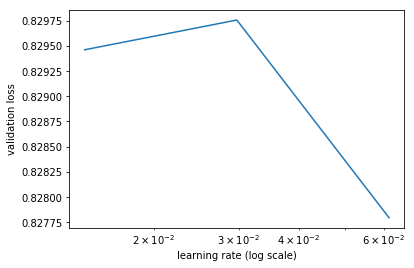

In [39]:
lrf = learn.lr_find()
learn.sched.plot()

In [40]:
lr = 0.2

In [41]:
learn.fit(lr,3,cycle_len = 1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.611857   0.417805   0.536849  
    1      0.401631   0.161084   0.851375                                                                              
    2      0.295305   0.155217   0.854336                                                                              
    3      0.242156   0.141572   0.877175                                                                              
    4      0.208741   0.138158   0.876913                                                                              
    5      0.187157   0.137173   0.882702                                                                              
    6      0.173368   0.136558   0.881631                                                                              



[array([0.13656]), 0.8816311634338008]

In [42]:
lrs = [lr/9 , lr/3 , lr]

In [43]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len = 1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.197619   0.17709    0.850973  
    1      0.17727    0.140893   0.873771                                                                              
    2      0.159438   0.129289   0.893102                                                                              
    3      0.149025   0.139281   0.874528                                                                              
    4      0.142314   0.126331   0.887902                                                                              
    5      0.134116   0.118105   0.889223                                                                              
    6      0.126657   0.114945   0.895547                                                                              



[array([0.11494]), 0.8955470373069299]

In [48]:
learn.save(f'{sz}')

In [49]:
sz=128

In [50]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 1, cycle_len=1) #, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.118269   0.118053   0.902653  



[array([0.11805]), 0.9026533440942578]

In [51]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.125384   0.118547   0.889558  
    1      0.119683   0.110214   0.912507                                                                              
    2      0.112897   0.10538    0.909264                                                                              
    3      0.110354   0.118409   0.894977                                                                              
    4      0.106633   0.111506   0.906715                                                                              
    5      0.102959   0.105794   0.905712                                                                              
    6      0.098249   0.104667   0.906177                                                                              



In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multy_preds , y = learn.TTA()
preds = np.mean(multy_preds,0)

In [ ]:
f2(preds,y)